## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
class Data:
    def __init__(self, train_features_file, test_file, train_target_file, target_feature, id_feature , cat_feautes, num_features):
        '''create train and test dataframe'''
        self.target_feature = target_feature
        self.cat_features = cat_feautes
        self.num_features = num_features
        self.features = cat_feautes + num_features
        self.id_feature = id_feature
        self.label_encoders = {}
        self.train_df = self._creating_train_df(train_features_file, train_target_file)
        self.test_df = self._creating_test_df(test_file)
        
    def label_encode_df(self, df, cols):
        '''create one label encoder for each column in the data object instance'''
        for col in cols:
            if col in self.label_encoders:
                #if label encoder already exits for col, use it
                self._label_encode(df, col, self.label_encoders[col])
            else:
                self._label_encode(df, col)
    
    def _label_encode(self, df, col, le=None):
        '''label encodes data'''
        if le:
            df[col] = le.transform(df[col])
        else:
            le = LabelEncoder()
            le.fit(df[col])
            df[col] = le.transform(df[col])
            self.label_encoders[col] = le
    
    def _loading_data(self, file):
        """ load data"""
        return pd.read_csv(file)
    
    def _creating_train_df(self, train_features_df, train_target_df, preprocessing=True, label_encode=True):
        ''' loads and merges training data features and target, preprocesses data and encodes data'''
        train_features_df = self._loading_data(train_features_df)
        train_target_df = self._loading_data(train_target_df)
        train_df = self._merge_dfs(train_features_df, train_target_df, key=self.id_feature)
        
        if preprocessing:
            train_df = self._cleaning_df(train_df)
            train_df = self._shuffle_df(train_df)
            
        if label_encode:
            self.label_encode_df(train_df, self.cat_features)
        return train_df
    
    def _creating_test_df(self, test_features_df, label_encode=True):
        ''' loads and encodes testing data '''
        test_df = self._loading_data(test_features_df)
        
        if label_encode:
            self.label_encode_df(test_df, self.cat_features)
        return test_df
    
    def _merge_dfs(self, df1, df2, key=None, left_index=False, right_index=False):
        ''' mearges data'''
        return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)
    
    def _cleaning_df(self, df):
        ''' removes duplicated job_id and  salary == 0'''
        df = df.drop_duplicates(subset=self.id_feature)
        df = df[df[self.target_feature] > 0]
        return df
    
    def _shuffle_df(self, df):
        ''' shuffles data'''
        return shuffle(df).reset_index(drop=True)

In [3]:
class ModelContainer:
    '''train training data and '''
    def __init__(self, data, models=[]):
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
    
    def add_model(self, model):
        self.models.append(model)
    
    def cross_validate(self, data, k=3, num_procs=1):
        '''cross validate models using given data'''
        for model in self.models:
            neg_mse = cross_val_score(model, data.train_df[data.cat_features+data.num_features], data.train_df[data.target_feature], cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
    
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
    
    def get_feature_importance(self, model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_mse:
            print('\n', model, '- MSE:', models.mean_mse[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_mse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.features))

        feature_importances = self.get_feature_importance(models.best_model, data.features)
        feature_importances.plot.bar()
        plt.show()

In [3]:
#define input files
train_feature_file = 'Downloads/data/train_features.csv'
train_target_file = 'Downloads/data/train_salaries.csv'
test_file = 'Downloads/data/test_features.csv'

#define variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'
id_col = 'jobId'

#define number of processors to use for parallel runs
num_procs = 4
k = 2
#set verbose level for models
verbose_lvl = 0

#turn feature engineering on/off
engineer_features = True

In [4]:
data = Data(train_feature_file, test_file, train_target_file, target_col, id_col, cat_cols, num_cols)

In [6]:
#create model container
models = ModelContainer(data)
#create models -- with default parameters for each model
models.add_model(LinearRegression())
models.add_model(RandomForestRegressor())
models.add_model(GradientBoostingRegressor())

## Cross validate models, then select, fit, and score test data with best model

In [7]:
models.cross_validate(data, k=k, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[cat_cols+num_cols], data.train_df[target_col])
models.best_model_predict(data.test_df[cat_cols+num_cols])


Model Summaries:


 LinearRegression() - MSE: 925.1107064959633

 RandomForestRegressor() - MSE: 411.46724320021883

 GradientBoostingRegressor() - MSE: 386.46256880196756

Best Model:
 GradientBoostingRegressor()

MSE of Best Model
 386.46256880196756

Feature Importances
                      importance
feature                        
jobType                0.434747
yearsExperience        0.191309
milesFromMetropolis    0.128758
industry               0.113268
major                  0.100618
degree                 0.031299
companyId              0.000000


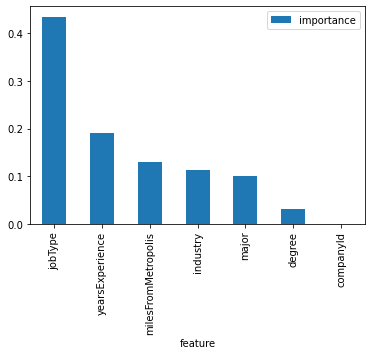

In [8]:
models.print_summary()